In [1]:
# TGS Machine Learning Notebook VERSION 2
# Created by Brandon Clary
# 8/15/2016


import os
import sys
import cv2
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import math
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("white")

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, erosion, dilation
from skimage.morphology import disk

import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Dropout, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import SGD
import keras.applications
from keras.losses import binary_crossentropy
from keras.preprocessing import image


import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/kuantumlad/.local/lib/python2.7/site-packages/pandas/core/indexes/bas

/home/kuantumlad/.local/lib/python2.7/site-packages/scipy/signal/_peak_finding.py:13: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._peak_finding_utils import (_argmaxima1d, _select_by_peak_distance,
/home/kuantumlad/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/kuantumlad/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/home/kuantumlad/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/home/kuantumlad/.local/lib/python2.7/site-packages/sklea

In [2]:
# set path relative to current directory
os.path.join(os.path.curdir, 'input/')
ABS_INPUT_PATH = os.path.join(os.path.curdir, 'input/') #/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/'
TEST_PATH = 'test/'
TRAIN_PATH = 'train/'
MASKS_PATH = 'masks/'
IMAGES_PATH = 'images/'
DEPTH_PATH = ABS_INPUT_PATH + TRAIN_PATH + 'depths.csv'
IMAGE_PROPERTIES = (128,128,1)
ORIGINAL_IMG_PROPERTIES = (101,101,1)

In [3]:
#training_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/training_id.txt"
#training_df = pd.read_csv(training_data, index_col="id", usecols=[0])
training_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/training_id.txt"
depth_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/depths.csv"
train_df = pd.read_csv(training_data, index_col="id", usecols=[0])
depths_df = pd.read_csv(depth_data, index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/images/{}.png".format(idx), color_mode="grayscale")) for idx in tqdm_notebook(train_df.index)]


In [5]:
train_df["masks"] = [np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/train/masks/{}.png".format(idx),color_mode="grayscale"))/255 for idx in tqdm_notebook(train_df.index)]

In [21]:
#testing_data = "/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/test/testing_id.txt"
#test_df = pd.read_csv(testing_data, index_col="id", usecols=[0])

In [6]:
def bin_coverage(val):
    for i in range(0,21):
        if val * 20 <= i:
            return i

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(ORIGINAL_IMG_PROPERTIES[0], 2)

train_df["coverage_class"] = train_df.coverage.map(bin_coverage)


Text(0.5,0,'Coverage class')

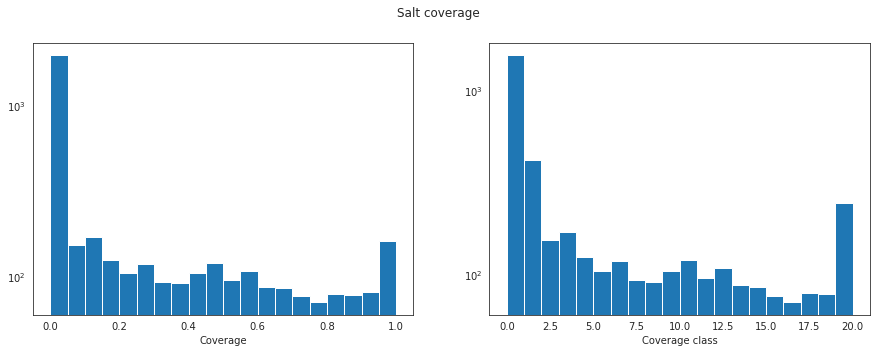

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].hist(train_df.coverage, bins=20)
axs[0].set_yscale('log')
axs[1].hist(train_df.coverage_class, bins=20)
axs[1].set_yscale('log')
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

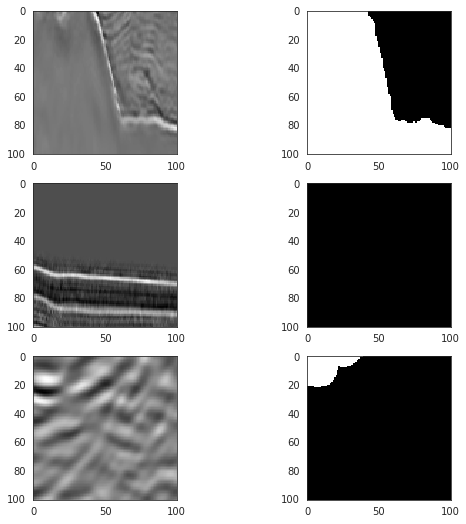

In [9]:
img_names = train_df.index[10:16]
img = train_df.loc[img_names[5]].images
mask = train_df.loc[img_names[5]].masks
    
fig, axs = plt.subplots(3,2,figsize=(9,9))
k = 0
for i in range(3):
    img = train_df.loc[img_names[k]].images
    mask = train_df.loc[img_names[k]].masks
    axs[i,0].imshow(img,cmap='gray')
    axs[i,1].imshow(mask,cmap='gray')
    k=k+1

In [10]:
def downscale(input_image, resized_shape=(101,101,1)):
    height, width, channels = input_image.shape
    h_start = (height - resized_shape[0]) // 2
    w_start = (width - resized_shape[1]) // 2
    return input_image[h_start:resized_shape[0]+h_start, w_start:resized_shape[1]+w_start, :]


def upscale(input_image, resized_shape=(128,128,1)):
    new_image = np.zeros(shape=resized_shape)
    height = input_image.shape[0]
    width = input_image.shape[1]
    h_start = (resized_shape[0] - height) // 2
    w_start = (resized_shape[1] - width) // 2
    new_image[h_start:height+h_start, w_start:width+w_start,0] = input_image
    
    return new_image

In [11]:
# Split into training and validation set
#ids_train, ids_val, x_train, x_val, y_train, y_val = train_test_split(training_df.index.values,
#                                                np.array(training_df.images.map(upscale).tolist()).reshape(-1, 128,128, 1), 
#                                                np.array(training_df.masks.map(upscale).tolist()).reshape(-1, 128,128, 1), 
#                                                stratify = training_df.coverage_class,
#                                                test_size=0.2)
ids_train, ids_val, x_train, x_val, y_train, y_val, cov_train, cov_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upscale).tolist()).reshape(-1, 128,128, 1), 
    np.array(train_df.masks.map(upscale).tolist()).reshape(-1, 128,128, 1), 
    train_df.coverage.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [12]:
print train_df.images.loc[ids_train[1]].shape
print (x_train[0]).shape

(101, 101)
(128, 128, 1)


In [13]:
#check image
tmp_img = np.zeros( (101, 101), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_img[:128, :128] = train_df.images.loc[ids_train[10]]

tmp_upscale = np.zeros( ( 128,128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_upscale[:128,:128] = x_train[10].squeeze()


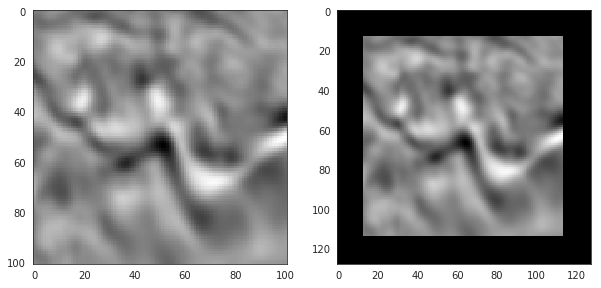

In [14]:
fig3, axs3 = plt.subplots(1,2, figsize=(10,10))
axs3[0].imshow(tmp_img,cmap='gray')
axs3[1].imshow(tmp_upscale, cmap='gray')

In [15]:
#AUG DATA
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [16]:
print len(x_train)

6400


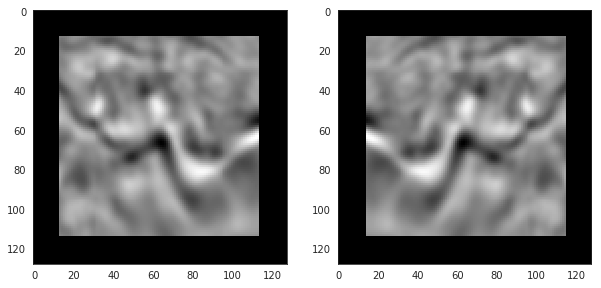

In [17]:
fig4, axs4 = plt.subplots(1,2, figsize=(10,10))
tmp_og = np.zeros( (128, 128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_og[:128, :128] = x_train[10].squeeze()

tmp_aug = np.zeros( ( 128,128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_aug[:128,:128] = x_train[len(x_train)/2 + 10].squeeze()
axs4[0].imshow(tmp_og, cmap='gray')
axs4[1].imshow(tmp_aug, cmap='gray')

In [23]:
datagen_args = dict(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=5,
    validation_split=0.2
    )

image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
## fit the augmentation model to the images and masks with the same seed
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)





KeyboardInterrupt: 

In [25]:
# combine generators into one which yields image and masks
print ('start image generator')
image_generator = image_datagen.flow(
        x_train,
        batch_size=8,
        shuffle=True,
        seed=seed)
print('start label generator')

## set the parameters for the data to come from (masks)
mask_generator = mask_datagen.flow(
        y_train,
        batch_size=8,
        shuffle=True,
        seed=seed)


start image generator
start label generator
start zip


In [27]:
print('start zip')
# combine generators into one which yields image and masks
def combineGenerator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())
train_generator = combineGenerator(image_generator, mask_generator)
print ('end zip')

start zip
end zip


(6400, 128, 128, 1)
(6400, 128, 128, 1)
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


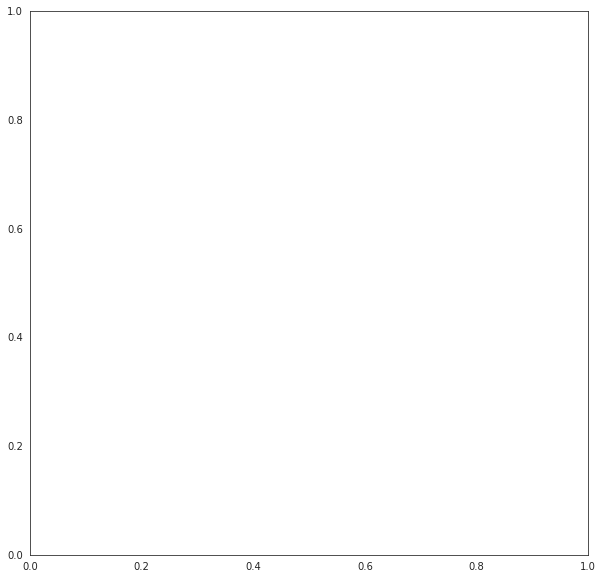

In [49]:
print mask_generator.x.shape
print image_generator.x.shape
print image_generator.x[10]

fig5, axs5 = plt.subplots(1,1, figsize=(10,10))
tmp_og = np.zeros( (128, 128), dtype=train_df.images.loc[ids_train[2]].dtype)
tmp_og[:128, :128] = image_generator.x[10].squeeze()

#tmp_aug = np.zeros( ( 128,128), dtype=train_df.images.loc[ids_train[2]].dtype)
#tmp_aug[:128,:128] = x_train[len(x_train)/2 + 10].squeeze()
axs4[0].imshow(tmp_og, cmap='gray')
#axs4[1].imshow(tmp_aug, cmap='gray')

In [28]:
###
## Model Related Items
###
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

sys.stdout.flush()

In [29]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(smooth):
  def dice(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred, smooth)
  return dice

def bce_dice_loss(y_true,y_pred):
    score = binary_crossentropy(y_true,y_pred) + (1-dice_coef(y_true,y_pred,1e-5))
    return score

In [30]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), activation="elu", padding="same", strides=strides, name=prefix + "_conv1")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv) 
    #conv = Conv2D(filters, (3, 3), activation="elu", padding="same", strides=strides, name=prefix + "_conv2")(conv)
    #conv = BatchNormalization(name=prefix + "_bn")(conv) 
    #conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [31]:
def get_unet_simple(input_shape, n_filters = 2):
    img_input = Input(input_shape)
    
    conv1 = conv_block_simple(img_input, n_filters*1, "conv1_1")
    conv1 = conv_block_simple(conv1, n_filters*1, "conv1_2")
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding="same", name="pool1")(conv1)
    
    conv2 = conv_block_simple(pool1, n_filters*2, "conv2_1")
    conv2 = conv_block_simple(conv2, n_filters*2, "conv2_2")
    pool2 = MaxPooling2D((2,2), strides=(2,2), padding="same", name="pool2")(conv2)
    
    conv3 = conv_block_simple(pool2, n_filters*4, "conv3_1")
    conv3 = conv_block_simple(conv3, n_filters*4, "conv3_2")
    pool3 = MaxPooling2D((2,2), strides=(2,2), padding="same", name="pool3")(conv3)
    
    conv4 = conv_block_simple(pool3, n_filters*16, "conv4_1")
    conv4 = conv_block_simple(conv4, n_filters*16, "conv4_2")
    pool4 = MaxPooling2D((2,2), strides=(2,2), padding="same", name="pool4")(conv4)
    
    conv5 = conv_block_simple(pool4, n_filters*32, "conv5_1")
    conv5 = conv_block_simple(conv5, n_filters*32, "conv5_2")
    pool5 = MaxPooling2D((2,2), strides=(2,2), padding="same", name="pool5")(conv5)
    
    mid = conv_block_simple(pool5, n_filters*64, "middle_1")
    mid = conv_block_simple(mid, n_filters*64, "middle_2")
    mid = conv_block_simple(mid, n_filters*64, "middle_3")

    cu6 = Conv2DTranspose(n_filters*32, (2, 2), strides=(2, 2), padding='same') (mid) #512 where n_filters is
    cu6 = concatenate([cu6, conv5])
    conv6 = conv_block_simple(cu6, n_filters*32, "conv6_1")
    conv6 = conv_block_simple(conv6, n_filters*32, "conv6_2")

    cu7 = Conv2DTranspose(n_filters*16, (2, 2), strides=(2, 2), padding='same') (conv6)
    cu7 = concatenate([cu7, conv4])
    conv7 = conv_block_simple(cu7,  n_filters*16, "conv7_1")
    conv7 = conv_block_simple(conv7,  n_filters*16, "conv7_2")
    
    cu8 = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same') (conv7)
    cu8 = concatenate([cu8, conv3])
    conv8 = conv_block_simple(cu8, n_filters*4, "conv8_1")
    conv8 = conv_block_simple(conv8, n_filters*4, "conv8_2")
    
    cu9 = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same') (conv8)
    cu9 = concatenate([cu9, conv2])
    conv9 = conv_block_simple(cu9, n_filters*2, "conv9_1")
    conv9 = conv_block_simple(conv9, n_filters*2, "conv9_2")

    cu10 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (conv9)
    cu10 = concatenate([cu10, conv1])
    conv10 = conv_block_simple(cu10, n_filters*1, "conv10_1")
    conv10 = conv_block_simple(conv10, n_filters*1, "conv10_2")
    
    prediction = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    model = Model(img_input, prediction)
    return model

In [32]:
model = get_unet_simple(IMAGE_PROPERTIES,4)

In [33]:
sgd = SGD(lr=0.001, momentum=0.7, decay=1e-6, nesterov=True)
model.compile(optimizer=sgd, loss=bce_dice_loss, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv1_1_conv1 (Conv2D)          (None, 128, 128, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_bn (BatchNormalization) (None, 128, 128, 4)  16          conv1_1_conv1[0][0]              
__________________________________________________________________________________________________
conv1_2_conv1 (Conv2D)          (None, 128, 128, 4)  148         conv1_1_bn[0][0]                 
__________________________________________________________________________________________________
conv1_2_bn

In [37]:
import time
timestr = time.strftime("%m%d_%H%M")
model_name = 'model-tgs-salt_' + timestr + '.h5'

print model_name

model-tgs-salt_0827_0116.h5


In [39]:
def fit_model( model_name, model, x_train, y_train, x_val, y_val, batch_size = 8, epochs=200 ):
    earlystopper = EarlyStopping(patience=10, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    
    results = model.fit(x_train, y_train, 
                        validation_data=[x_val,y_val], 
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[earlystopper, checkpointer, reduce_lr], shuffle=True)
    return results

model-tgs-salt_0826_2046.h5


In [38]:
def fit_generator_model( model_name, model, combinedGenerator, batch_size = 8, epochs=200 ):
    earlystopper = EarlyStopping(patience=10, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    
    results = model.fit_generator(combinedGenerator, 
                        steps_per_epoch=1000,#steps_per_epoch, from number of images / batch size
                        epochs=epochs, 
                        callbacks=[earlystopper, checkpointer, reduce_lr], 
                        shuffle=True, 
                        verbose=1)
    return results


In [39]:
print len(y_val)
my_generator_model = fit_generator_model(model_name,model,train_generator)

800
Epoch 1/200
100/100 [==============================] - 9s 89ms/step - loss: 1.0631 - acc: 0.1806
Epoch 2/200
  3/100 [..............................] - ETA: 5s - loss: 0.2803 - acc: 0.1143 

/home/kuantumlad/.local/lib/python2.7/site-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/kuantumlad/.local/lib/python2.7/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/kuantumlad/.local/lib/python2.7/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: acc,loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


100/100 [==============================] - 6s 58ms/step - loss: 0.6402 - acc: 0.2168
Epoch 3/200
100/100 [==============================] - 6s 58ms/step - loss: 0.2548 - acc: 0.2741
Epoch 4/200
100/100 [==============================] - 6s 58ms/step - loss: -0.0641 - acc: 0.3169
Epoch 5/200
100/100 [==============================] - 6s 58ms/step - loss: -0.5634 - acc: 0.3411
Epoch 6/200
100/100 [==============================] - 6s 58ms/step - loss: -1.0616 - acc: 0.3895
Epoch 7/200
100/100 [==============================] - 6s 59ms/step - loss: -1.6381 - acc: 0.3903
Epoch 8/200
100/100 [==============================] - 6s 58ms/step - loss: -2.3423 - acc: 0.3874
Epoch 9/200
100/100 [==============================] - 6s 58ms/step - loss: -2.7269 - acc: 0.3988
Epoch 10/200
100/100 [==============================] - 6s 58ms/step - loss: -3.1365 - acc: 0.4223
Epoch 11/200
100/100 [==============================] - 6s 58ms/step - loss: -3.8299 - acc: 0.3544
Epoch 12/200
100/100 [==========

KeyboardInterrupt: 

In [44]:
#my_model = fit_model(model_name, model, x_train, y_train, x_val, y_val)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 82s 13ms/step - loss: 1.0882 - acc: 0.7693 - val_loss: 0.7572 - val_acc: 0.9037

Epoch 00001: val_loss improved from inf to 0.75723, saving model to model-tgs-salt_0826_2046.h5
Epoch 2/200
6400/6400 [==============================] - 78s 12ms/step - loss: 0.7186 - acc: 0.8991 - val_loss: 0.5872 - val_acc: 0.9286

Epoch 00002: val_loss improved from 0.75723 to 0.58723, saving model to model-tgs-salt_0826_2046.h5
Epoch 3/200
6400/6400 [==============================] - 79s 12ms/step - loss: 0.6073 - acc: 0.9164 - val_loss: 0.5437 - val_acc: 0.9324

Epoch 00003: val_loss improved from 0.58723 to 0.54365, saving model to model-tgs-salt_0826_2046.h5
Epoch 4/200
6400/6400 [==============================] - 79s 12ms/step - loss: 0.5387 - acc: 0.9277 - val_loss: 0.5599 - val_acc: 0.9323

Epoch 00004: val_loss did not improve from 0.54365
Epoch 5/200
6400/6400 [==============================]

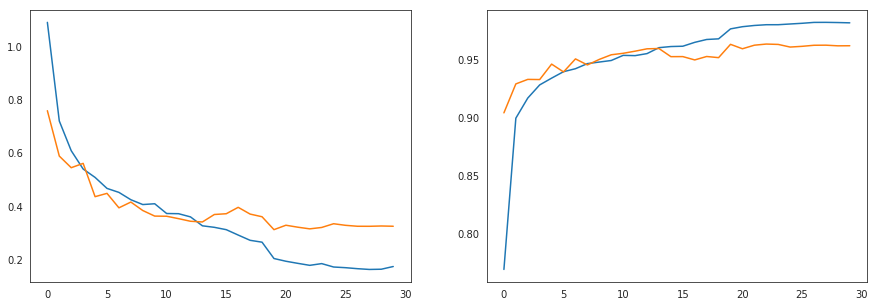

In [47]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(my_model.epoch, my_model.history["loss"], label="Train loss")
ax_loss.plot(my_model.epoch, my_model.history["val_loss"], label="Validation loss")
ax_acc.plot(my_model.epoch, my_model.history["acc"], label="Train accuracy")
ax_acc.plot(my_model.epoch, my_model.history["val_acc"], label="Validation accuracy")
fig.savefig('performance_plot_'+timestr+'.png')

In [48]:
model = load_model('model-tgs-salt_0826_2046.h5',  custom_objects={'bce_dice_loss':bce_dice_loss} )

In [49]:
predicted_validation = model.predict(x_val,verbose=1)#.reshape(-1,128,128)

800/800 [==============================] - 2s 3ms/step


In [51]:
predicted_validation = np.array([downscale(x) for x in predicted_validation])
ids_validation = np.array([train_df.loc[x].masks for x in ids_val])

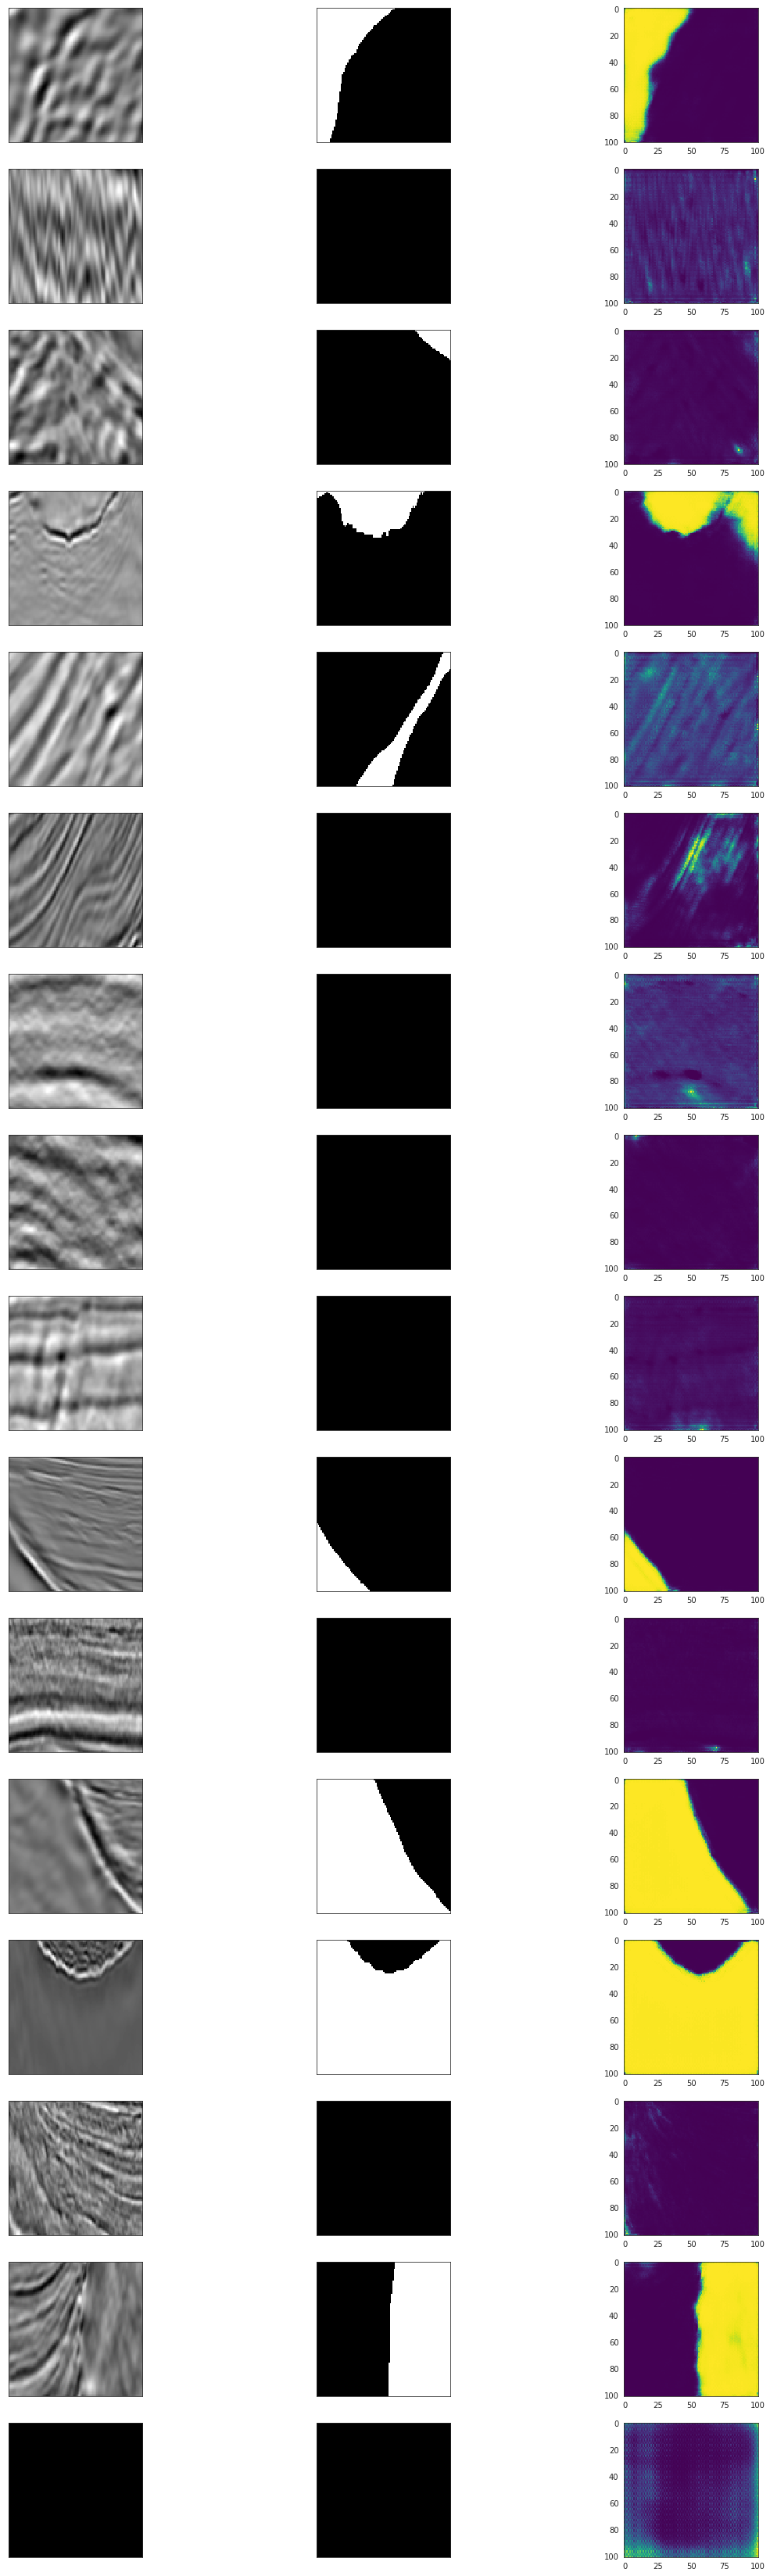

In [55]:
f, axarr = plt.subplots(16, 3, figsize=(20,60))

for i in range(16):
     
    j = np.random.randint(0,len(ids_validation))

    img = train_df.loc[ids_val[j]].images
    masks = train_df.loc[ids_val[j]].masks
    pred = predicted_validation[j][:,:,0]

    #print ids_val[j]
    
    axarr[i,0].imshow(img, cmap = 'gray')
    axarr[i,0].set_yticklabels([])
    axarr[i,0].set_xticklabels([])  
    axarr[i,1].imshow(masks, cmap = 'gray')
    axarr[i,1].set_yticklabels([])
    axarr[i,1].set_xticklabels([]) 
    axarr[i,2].imshow(pred, cmap = 'viridis',interpolation='none')
    #axarr[i,2].set_yticklabels([])
    #axarr[i,2].set_xticklabels([]) 

In [57]:
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_val])
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [58]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(predicted_validation > threshold)) for threshold in tqdm_notebook(thresholds)])

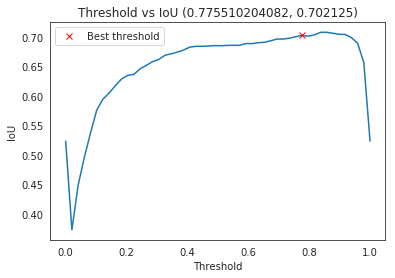

In [59]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [60]:
# Apply model to testing data to prepare for submission
x_test = np.array([upscale(np.array(load_img("/home/kuantumlad/Documents/projects/kaggle/kaggle-tgs_salt/input/test/images/{}.png".format(idx), color_mode="grayscale"))) for idx in tqdm_notebook(test_df.index)]).reshape(-1, 128, 128, 1)


In [61]:
print x_test.shape

(18000, 128, 128, 1)


In [62]:
#pred_model = load_model('model-tgs-salt_0825_1827.h5',  custom_objects={'bce_dice_loss':bce_dice_loss} )
pred_test = model.predict(x_test,verbose=1)

18000/18000 [==============================] - 40s 2ms/step


(18000, 128, 128, 1)
(18000, 128, 128, 1)


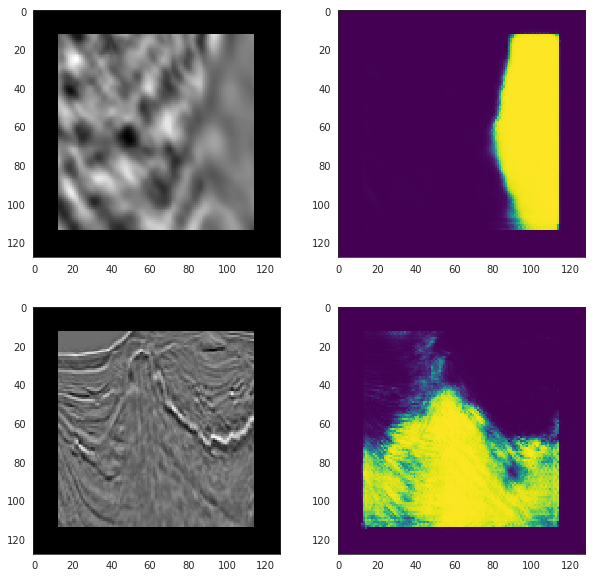

In [72]:
fig ,ax = plt.subplots(2,2,figsize=(10,10))
print pred_test.shape
test_pics = np.array([downscale(x) for x in pred_test])
print x_test.shape
ax[0,0].imshow(np.squeeze(x_test[579]),cmap='gray')
ax[0,1].imshow(np.squeeze(pred_test[579]),cmap='viridis')
ax[1,0].imshow(np.squeeze(x_test[2819]),cmap='gray')
ax[1,1].imshow(np.squeeze(pred_test[2819]),cmap='viridis')

In [67]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [129]:
#def filterGaus(temp_image):
 #   return cv2.GaussianBlur(temp_image,(7,7),0)

#pred_test2 = [ filterGaus(x) for x in pred_test ]

In [68]:

preds_test_t = (pred_test > threshold_best).astype(np.uint8)

predicted_final = [ downscale(x) for x in preds_test_t]

(101, 101, 1)


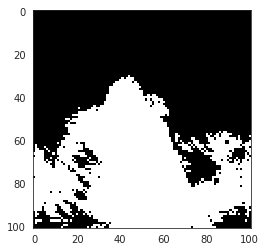

In [73]:
plt.imshow(predicted_final[2819].squeeze(), cmap='gray')
print predicted_final[2819].shape

In [74]:
def filterGaus(temp_image):
    return cv2.GaussianBlur(temp_image,(7,7),0)

predicted_final_gblur = [ filterGaus(x) for x in predicted_final ]

(101, 101)


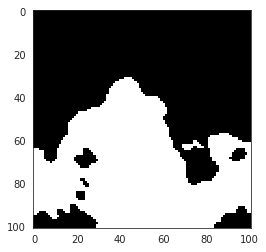

In [75]:
plt.imshow(predicted_final_gblur[2819].squeeze(), cmap='gray')
print predicted_final_gblur[2819].shape

In [76]:
#pred_dict = {idx: RLenc(np.round(downscale(pred_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
pred_dict = {idx: RLenc(np.round(predicted_final_gblur[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [77]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submissionv2b_'+model_name+'.csv')

In [133]:
print x_val.shape
print x_test.shape
print predicted_final[0].shape

(800, 128, 128, 1)
(18000, 128, 128, 1)
(101, 101, 1)
